# Analisis Voice (Audio) menggunakan TSFEL 

**Feature extraction audio (voice)** dengan [TSFEL] untuk klasifikasi suara "buka" dan "tutup"

## 0) Persiapan lingkungan (install & import)

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Audio utils
import soundfile as sf  # baca/tulis wav
import librosa          # pemrosesan audio
import librosa.display

# TSFEL
import tsfel

## 1) Muat semua file audio dari folder buka dan tutup

Loading 100 file dari folder 'buka'...
Loading 100 file dari folder 'tutup'...
Loading 100 file dari folder 'tutup'...

Total audio loaded: 200
Buka: 100, Tutup: 100
Sampling rate: 16000 Hz

Total audio loaded: 200
Buka: 100, Tutup: 100
Sampling rate: 16000 Hz


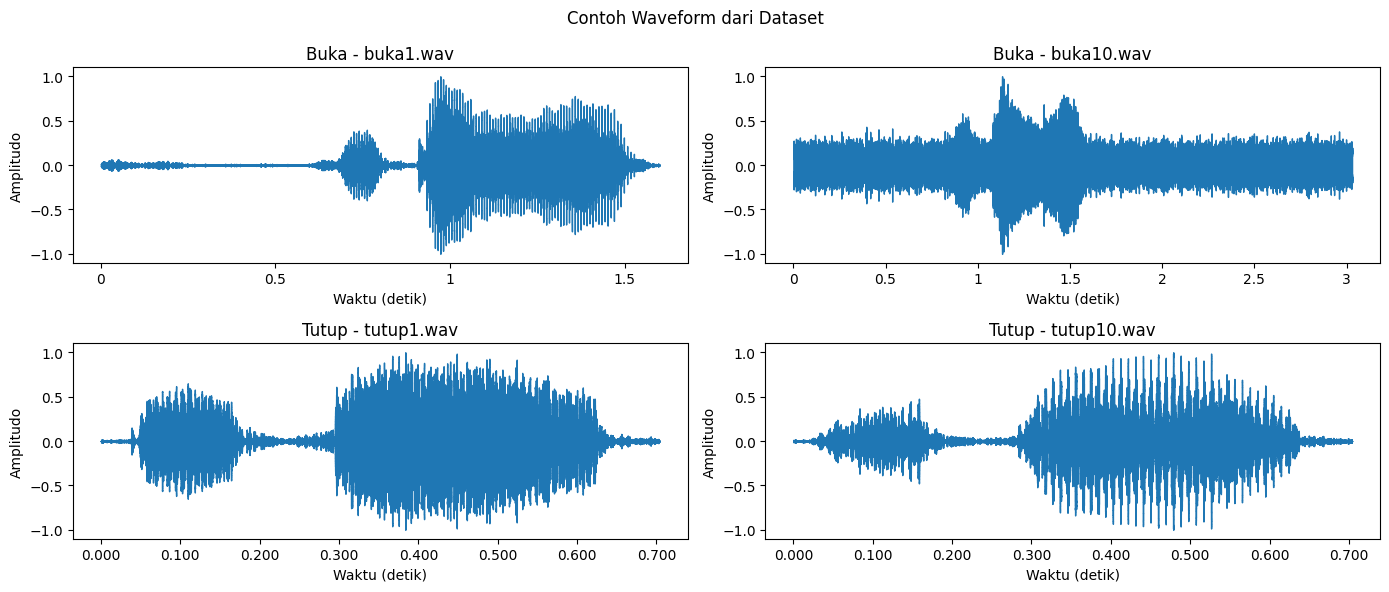

In [19]:
import os
from pathlib import Path

# Path ke folder dataset
BUKA_PATH = './voice/buka/'
TUTUP_PATH = './voice/tutup/'

# Parameter sampling
TARGET_SR = 16000  # 16 kHz umum untuk speech

# Fungsi untuk memuat dan preprocess audio
def load_audio_file(file_path, sr=16000):
    """Memuat file audio, trim silence, dan normalisasi"""
    y, sample_rate = librosa.load(file_path, sr=sr, mono=True)
    
    # Trim silence di awal/akhir
    y_trimmed, _ = librosa.effects.trim(y, top_db=25)
    
    # Normalisasi amplitudo
    if np.max(np.abs(y_trimmed)) > 0:
        y_trimmed = y_trimmed / np.max(np.abs(y_trimmed))
    
    return y_trimmed, sample_rate

# Kumpulkan semua file audio
audio_data = []
labels = []
filenames = []

# Load file dari folder buka
buka_files = sorted([f for f in os.listdir(BUKA_PATH) if f.endswith('.wav')])
print(f"Loading {len(buka_files)} file dari folder 'buka'...")
for file in buka_files:
    file_path = os.path.join(BUKA_PATH, file)
    y, sr = load_audio_file(file_path, TARGET_SR)
    audio_data.append(y)
    labels.append(0)  # Label 0 untuk "buka"
    filenames.append(file)

# Load file dari folder tutup
tutup_files = sorted([f for f in os.listdir(TUTUP_PATH) if f.endswith('.wav')])
print(f"Loading {len(tutup_files)} file dari folder 'tutup'...")
for file in tutup_files:
    file_path = os.path.join(TUTUP_PATH, file)
    y, sr = load_audio_file(file_path, TARGET_SR)
    audio_data.append(y)
    labels.append(1)  # Label 1 untuk "tutup"
    filenames.append(file)

print(f"\nTotal audio loaded: {len(audio_data)}")
print(f"Buka: {labels.count(0)}, Tutup: {labels.count(1)}")
print(f"Sampling rate: {TARGET_SR} Hz")

# Visualisasi beberapa contoh waveform
fig, axes = plt.subplots(2, 2, figsize=(14, 6))
fig.suptitle('Contoh Waveform dari Dataset')

# Plot 2 contoh dari "buka"
for i in range(2):
    librosa.display.waveshow(audio_data[i], sr=TARGET_SR, ax=axes[0, i])
    axes[0, i].set_title(f'Buka - {filenames[i]}')
    axes[0, i].set_xlabel('Waktu (detik)')
    axes[0, i].set_ylabel('Amplitudo')

# Plot 2 contoh dari "tutup"
buka_count = labels.count(0)
for i in range(2):
    librosa.display.waveshow(audio_data[buka_count + i], sr=TARGET_SR, ax=axes[1, i])
    axes[1, i].set_title(f'Tutup - {filenames[buka_count + i]}')
    axes[1, i].set_xlabel('Waktu (detik)')
    axes[1, i].set_ylabel('Amplitudo')

plt.tight_layout()
plt.show()

## 2) Analisis durasi audio dan statistik dasar

Statistik Durasi Audio (detik):
Buka  - Mean: 2.348, Std: 0.941, Min: 0.832, Max: 3.939
Tutup - Mean: 1.987, Std: 1.455, Min: 0.576, Max: 4.096


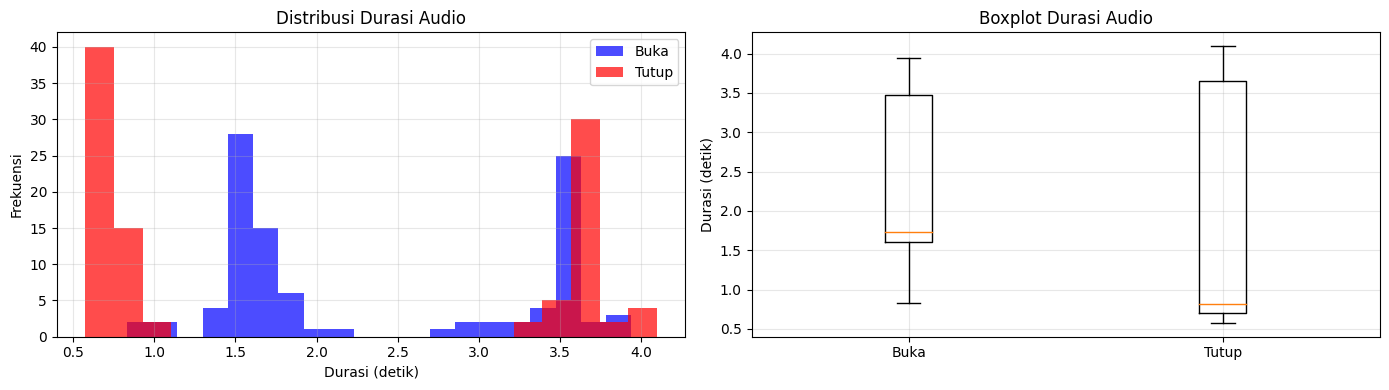

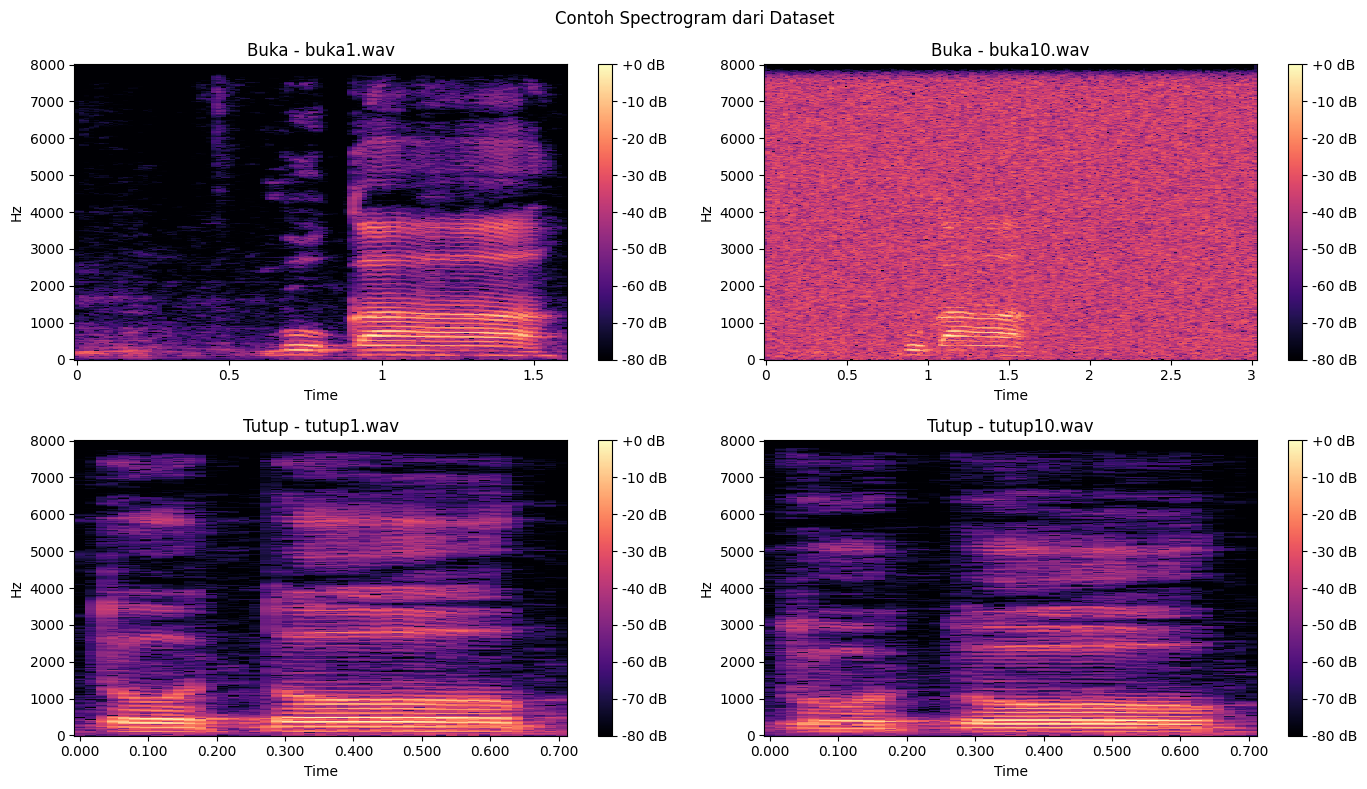

In [20]:
# Analisis durasi audio
durations = [len(y) / TARGET_SR for y in audio_data]
durations_buka = [d for d, l in zip(durations, labels) if l == 0]
durations_tutup = [d for d, l in zip(durations, labels) if l == 1]

# Statistik durasi
print("Statistik Durasi Audio (detik):")
print(f"Buka  - Mean: {np.mean(durations_buka):.3f}, Std: {np.std(durations_buka):.3f}, Min: {np.min(durations_buka):.3f}, Max: {np.max(durations_buka):.3f}")
print(f"Tutup - Mean: {np.mean(durations_tutup):.3f}, Std: {np.std(durations_tutup):.3f}, Min: {np.min(durations_tutup):.3f}, Max: {np.max(durations_tutup):.3f}")

# Visualisasi distribusi durasi
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(durations_buka, bins=20, alpha=0.7, label='Buka', color='blue')
axes[0].hist(durations_tutup, bins=20, alpha=0.7, label='Tutup', color='red')
axes[0].set_xlabel('Durasi (detik)')
axes[0].set_ylabel('Frekuensi')
axes[0].set_title('Distribusi Durasi Audio')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot durasi
axes[1].boxplot([durations_buka, durations_tutup], labels=['Buka', 'Tutup'])
axes[1].set_ylabel('Durasi (detik)')
axes[1].set_title('Boxplot Durasi Audio')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualisasi spectrogram untuk beberapa contoh
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('Contoh Spectrogram dari Dataset')

# Spectrogram 2 contoh dari "buka"
for i in range(2):
    S = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data[i], n_fft=1024, hop_length=256)), ref=np.max)
    img = librosa.display.specshow(S, sr=TARGET_SR, hop_length=256, x_axis='time', y_axis='linear', ax=axes[0, i])
    axes[0, i].set_title(f'Buka - {filenames[i]}')
    fig.colorbar(img, ax=axes[0, i], format='%+2.0f dB')

# Spectrogram 2 contoh dari "tutup"
buka_count = labels.count(0)
for i in range(2):
    S = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data[buka_count + i], n_fft=1024, hop_length=256)), ref=np.max)
    img = librosa.display.specshow(S, sr=TARGET_SR, hop_length=256, x_axis='time', y_axis='linear', ax=axes[1, i])
    axes[1, i].set_title(f'Tutup - {filenames[buka_count + i]}')
    fig.colorbar(img, ax=axes[1, i], format='%+2.0f dB')

plt.tight_layout()
plt.show()

## 3) Konfigurasi fitur TSFEL

In [21]:
# Ambil set fitur lintas domain: temporal, statistical, spectral
# Lihat dokumentasi: tsfel.get_features_by_domain()
cfg = tsfel.get_features_by_domain(["statistical"])  # semua domain
# Atau pilih subset, misal: cfg = tsfel.get_features_by_domain(['temporal','statistical','spectral'])

# Cek jumlah fitur yang akan diekstrak
n_feats = tsfel.get_number_features(cfg)
print('Jumlah fitur yang akan diekstrak:', n_feats)

# Anda bisa memodifikasi cfg (mis. mematikan fitur tertentu) sebelum ekstraksi:
# contoh: cfg['spectral']['spectral_centroid']['use'] = 'no'

Jumlah fitur yang akan diekstrak: 31


## 4) Ekstraksi fitur TSFEL untuk semua audio

Kita akan mengekstrak fitur untuk setiap file audio menggunakan TSFEL.
Strategi: Ekstrak fitur dari **seluruh sinyal** (full-signal) untuk setiap file audio, sehingga setiap file akan menghasilkan satu vektor fitur.

In [22]:
# Ekstraksi fitur untuk setiap file audio
print("Mengekstrak fitur TSFEL untuk setiap file audio...")

features_list = []
for i, (y, label) in enumerate(zip(audio_data, labels)):
    try:
        # Ekstrak fitur untuk seluruh sinyal (full-signal, bukan windowed)
        X = tsfel.time_series_features_extractor(cfg, y, fs=TARGET_SR, verbose=0)
        features_list.append(X.iloc[0].values)  # Ambil baris pertama sebagai array
        
        if (i + 1) % 20 == 0:
            print(f"Progress: {i + 1}/{len(audio_data)} file selesai...")
    except Exception as e:
        print(f"Error pada file {filenames[i]}: {str(e)}")
        features_list.append(np.full(n_feats, np.nan))

print(f"Ekstraksi fitur selesai untuk {len(features_list)} file audio.")

# Buat DataFrame dengan fitur
feature_names = list(X.columns)
X_all = pd.DataFrame(features_list, columns=feature_names)
X_all['label'] = labels
X_all['filename'] = filenames

print(f"\nShape fitur: {X_all.shape}")
print(f"Fitur: {X_all.shape[1] - 2} features + label + filename")
X_all.head()

Mengekstrak fitur TSFEL untuk setiap file audio...
Progress: 20/200 file selesai...
Progress: 20/200 file selesai...
Progress: 40/200 file selesai...
Progress: 40/200 file selesai...
Progress: 60/200 file selesai...
Progress: 60/200 file selesai...
Progress: 80/200 file selesai...
Progress: 80/200 file selesai...
Progress: 100/200 file selesai...
Progress: 100/200 file selesai...
Progress: 120/200 file selesai...
Progress: 120/200 file selesai...
Progress: 140/200 file selesai...
Progress: 140/200 file selesai...
Progress: 160/200 file selesai...
Progress: 160/200 file selesai...
Progress: 180/200 file selesai...
Progress: 180/200 file selesai...
Progress: 200/200 file selesai...
Ekstraksi fitur selesai untuk 200 file audio.

Shape fitur: (200, 33)
Fitur: 31 features + label + filename
Progress: 200/200 file selesai...
Ekstraksi fitur selesai untuk 200 file audio.

Shape fitur: (200, 33)
Fitur: 31 features + label + filename


,0_Absolute energy,0_Average power,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,0_ECDF_2,0_ECDF_3,...,0_Median,0_Median absolute deviation,0_Min,0_Peak to peak distance,0_Root mean square,0_Skewness,0_Standard deviation,0_Variance,label,filename
0,484.806112,303.015657,5120.0,20480.0,-0.033125,0.042615,0.000039,0.000078,0.000117,0.000156,...,0.000478,0.021979,-1.000000,1.784290,0.137614,-0.698921,0.137614,0.018938,0,buka1.wav
1,962.745336,317.770508,9695.0,38780.0,-0.096933,0.097816,0.000021,0.000041,0.000062,0.000083,...,-0.000383,0.077353,-0.886775,1.886775,0.140926,0.064636,0.140926,0.019860,0,buka10.wav
2,1110.563325,723.052419,4915.0,19660.0,-0.063337,0.063384,0.000041,0.000081,0.000122,0.000163,...,-0.000190,0.036831,-0.935962,1.935962,0.212577,0.042484,0.212577,0.045189,0,buka100.wav
3,536.351784,294.062589,5836.0,23347.0,-0.032422,0.041744,0.000034,0.000069,0.000103,0.000137,...,0.000466,0.021454,-1.000000,1.779988,0.135567,-0.701502,0.135566,0.018378,0,buka11.wav
4,913.908253,236.331389,12374.0,49499.0,-0.071491,0.071091,0.000016,0.000032,0.000048,0.000065,...,-0.000027,0.056428,-1.000000,1.954614,0.121534,0.039500,0.121534,0.014770,0,buka12.wav


## 5) Bersihkan fitur (NaN/Inf), simpan ke CSV

In [23]:
# Drop kolom yang seluruhnya NaN atau memiliki inf
X_clean = X_all.copy()
X_clean = X_clean.replace([np.inf, -np.inf], np.nan)

# Pisahkan label dan filename sebelum cleaning
y_labels = X_clean['label'].values
file_names = X_clean['filename'].values
X_features = X_clean.drop(columns=['label', 'filename'])

# Drop kolom yang all-NaN
drop_all_nan = [c for c in X_features.columns if X_features[c].isna().all()]
X_features = X_features.drop(columns=drop_all_nan)

# Drop kolom yang memiliki NaN (atau bisa imputasi)
drop_any_nan = [c for c in X_features.columns if X_features[c].isna().any()]
X_features = X_features.drop(columns=drop_any_nan)

print(f'Hapus kolom all-NaN: {len(drop_all_nan)} kolom')
print(f'Hapus kolom dengan NaN: {len(drop_any_nan)} kolom')
print(f'Shape setelah clean: {X_features.shape}')

# Gabungkan kembali dengan label dan filename
X_clean = X_features.copy()
X_clean['label'] = y_labels
X_clean['filename'] = file_names

print(f'\nDistribusi label:')
print(X_clean['label'].value_counts())
X_clean.head()

Hapus kolom all-NaN: 0 kolom
Hapus kolom dengan NaN: 0 kolom
Shape setelah clean: (200, 31)

Distribusi label:
label
0    100
1    100
Name: count, dtype: int64


,0_Absolute energy,0_Average power,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,0_ECDF_2,0_ECDF_3,...,0_Median,0_Median absolute deviation,0_Min,0_Peak to peak distance,0_Root mean square,0_Skewness,0_Standard deviation,0_Variance,label,filename
0,484.806112,303.015657,5120.0,20480.0,-0.033125,0.042615,0.000039,0.000078,0.000117,0.000156,...,0.000478,0.021979,-1.000000,1.784290,0.137614,-0.698921,0.137614,0.018938,0,buka1.wav
1,962.745336,317.770508,9695.0,38780.0,-0.096933,0.097816,0.000021,0.000041,0.000062,0.000083,...,-0.000383,0.077353,-0.886775,1.886775,0.140926,0.064636,0.140926,0.019860,0,buka10.wav
2,1110.563325,723.052419,4915.0,19660.0,-0.063337,0.063384,0.000041,0.000081,0.000122,0.000163,...,-0.000190,0.036831,-0.935962,1.935962,0.212577,0.042484,0.212577,0.045189,0,buka100.wav
3,536.351784,294.062589,5836.0,23347.0,-0.032422,0.041744,0.000034,0.000069,0.000103,0.000137,...,0.000466,0.021454,-1.000000,1.779988,0.135567,-0.701502,0.135566,0.018378,0,buka11.wav
4,913.908253,236.331389,12374.0,49499.0,-0.071491,0.071091,0.000016,0.000032,0.000048,0.000065,...,-0.000027,0.056428,-1.000000,1.954614,0.121534,0.039500,0.121534,0.014770,0,buka12.wav


## 6) Standarisasi & visualisasi (PCA 2D)

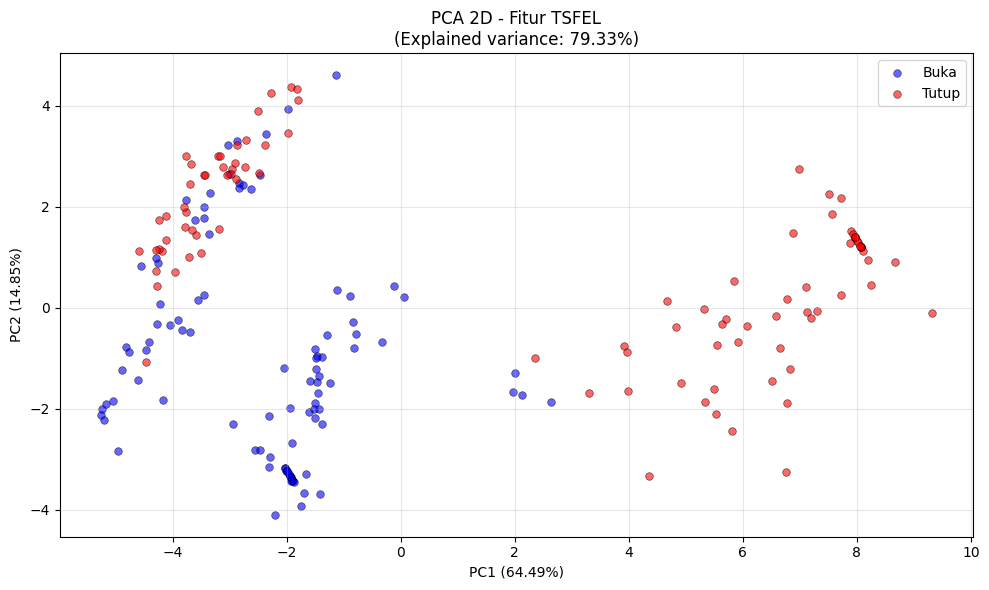


Fitur tersimpan ke: tsfel_voice_features.csv
Total sampel: 200, Total fitur: 31


In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Pisahkan fitur dan label
X_for_scaling = X_clean.drop(columns=['label', 'filename']).values
y_for_viz = X_clean['label'].values

# Standarisasi
scaler = StandardScaler()
Z = scaler.fit_transform(X_for_scaling)

# PCA 2D
pca = PCA(n_components=2, random_state=42)
Z2 = pca.fit_transform(Z)

# Visualisasi PCA
plt.figure(figsize=(10, 6))
colors = ['blue', 'red']
labels_name = ['Buka', 'Tutup']

for i in range(2):
    mask = y_for_viz == i
    plt.scatter(Z2[mask, 0], Z2[mask, 1], s=30, alpha=0.6, 
                c=colors[i], label=labels_name[i], edgecolors='k', linewidth=0.5)

plt.title(f'PCA 2D - Fitur TSFEL\n(Explained variance: {pca.explained_variance_ratio_.sum():.2%})')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Simpan fitur ke CSV
out_csv = 'tsfel_voice_features.csv'
X_clean.to_csv(out_csv, index=False)
print(f'\nFitur tersimpan ke: {out_csv}')
print(f'Total sampel: {len(X_clean)}, Total fitur: {X_clean.shape[1] - 2}')

## 7) Klasifikasi dengan berbagai algoritma

Kita akan menguji beberapa model klasifikasi untuk membedakan suara "buka" dan "tutup".

Training set: 160 sampel
Test set: 40 sampel

Model: Logistic Regression

Accuracy: 0.9250

Classification Report:
              precision    recall  f1-score   support

        Buka       0.90      0.95      0.93        20
       Tutup       0.95      0.90      0.92        20

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.92        40

Cross-validation scores: [0.925 0.95  0.925 0.925 0.9  ]
Mean CV accuracy: 0.9250 (+/- 0.0316)

Model: Random Forest

Accuracy: 0.9500

Classification Report:
              precision    recall  f1-score   support

        Buka       1.00      0.90      0.95        20
       Tutup       0.91      1.00      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40


Accuracy: 0.9500

Classification Report:
              precision    rec

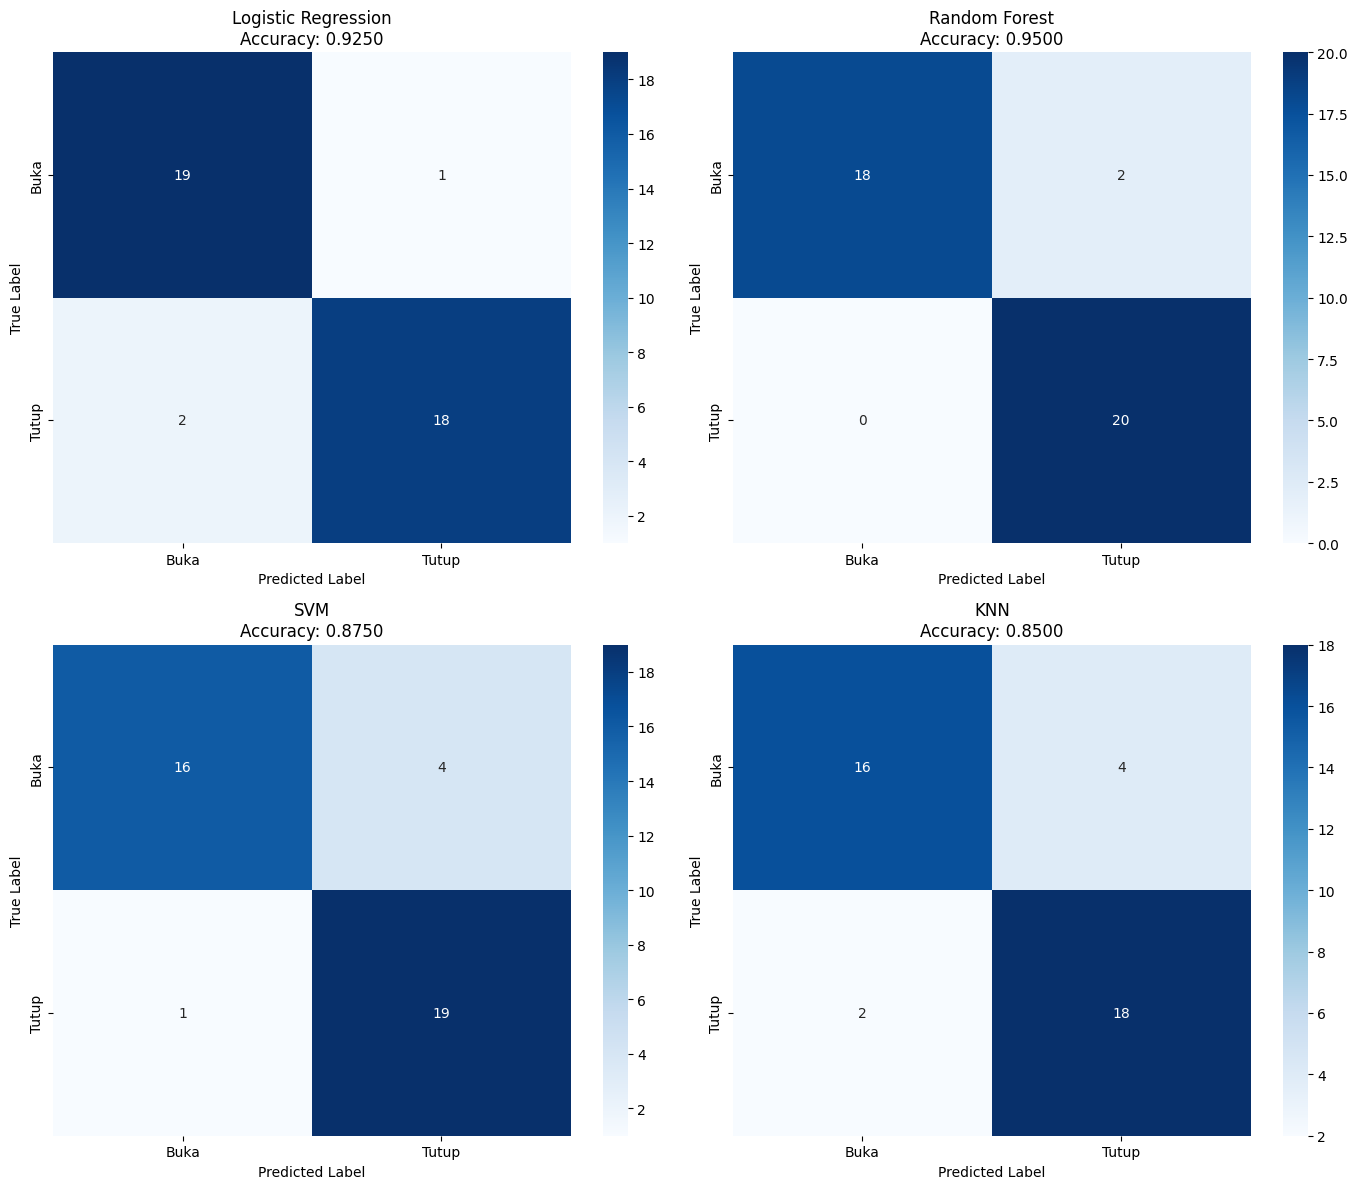

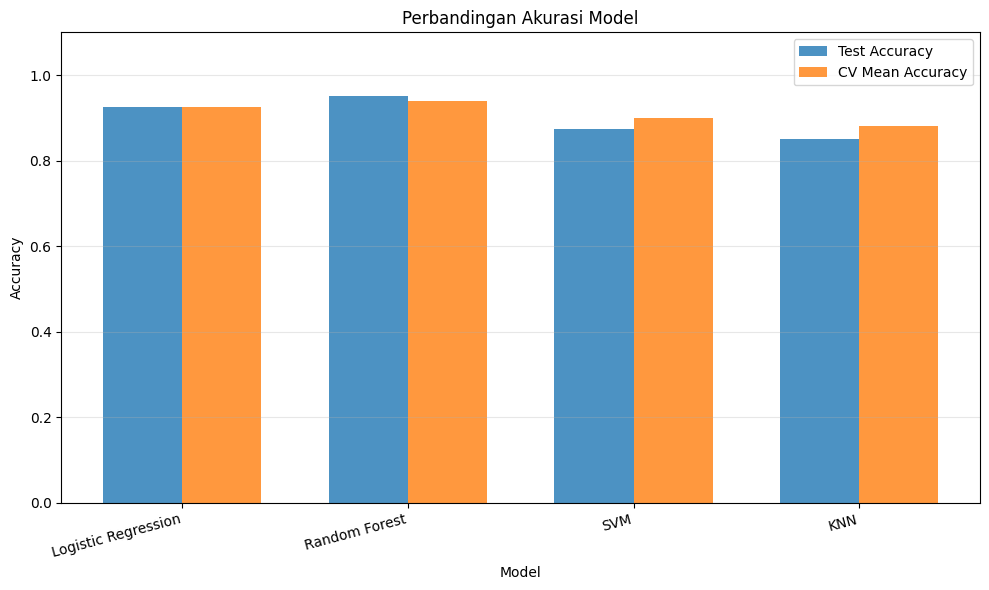

In [25]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    Z, y_for_viz, test_size=0.2, random_state=42, stratify=y_for_viz
)

print(f"Training set: {len(X_train)} sampel")
print(f"Test set: {len(X_test)} sampel")
print()

# Dictionary untuk menyimpan hasil
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

results = {}

# Train dan evaluasi setiap model
for name, model in models.items():
    print(f"{'='*50}")
    print(f"Model: {name}")
    print(f"{'='*50}")
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Buka', 'Tutup']))
    
    # Cross-validation score
    cv_scores = cross_val_score(model, Z, y_for_viz, cv=5)
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # Simpan hasil
    results[name] = {
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred
    }
    print()

# Visualisasi confusion matrix untuk model terbaik
best_model_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
print(f"\nModel terbaik: {best_model_name} dengan accuracy {results[best_model_name]['accuracy']:.4f}")

# Plot confusion matrix
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Buka', 'Tutup'], yticklabels=['Buka', 'Tutup'])
    axes[idx].set_title(f'{name}\nAccuracy: {result["accuracy"]:.4f}')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Plot perbandingan akurasi
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
model_names = list(results.keys())
accuracies = [results[m]['accuracy'] for m in model_names]
cv_means = [results[m]['cv_mean'] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

ax.bar(x - width/2, accuracies, width, label='Test Accuracy', alpha=0.8)
ax.bar(x + width/2, cv_means, width, label='CV Mean Accuracy', alpha=0.8)

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Perbandingan Akurasi Model')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

## 8) Analisis Feature Importance

Melihat fitur mana yang paling penting dalam membedakan suara "buka" dan "tutup" menggunakan Random Forest.

Top 20 Fitur Terpenting:
                        feature  importance
0             0_Absolute energy    0.068763
22    0_Mean absolute deviation    0.067242
24  0_Median absolute deviation    0.067145
18        0_Interquartile range    0.057368
11                     0_ECDF_5    0.057105
5           0_ECDF Percentile_1    0.053667
27           0_Root mean square    0.045904
1               0_Average power    0.043272
8                      0_ECDF_2    0.039789
4           0_ECDF Percentile_0    0.039317
30                   0_Variance    0.035406
29         0_Standard deviation    0.035326
13                     0_ECDF_7    0.034565
9                      0_ECDF_3    0.034230
7                      0_ECDF_1    0.032877
14                     0_ECDF_8    0.032653
6                      0_ECDF_0    0.032210
10                     0_ECDF_4    0.029840
19                   0_Kurtosis    0.029285
12                     0_ECDF_6    0.028812


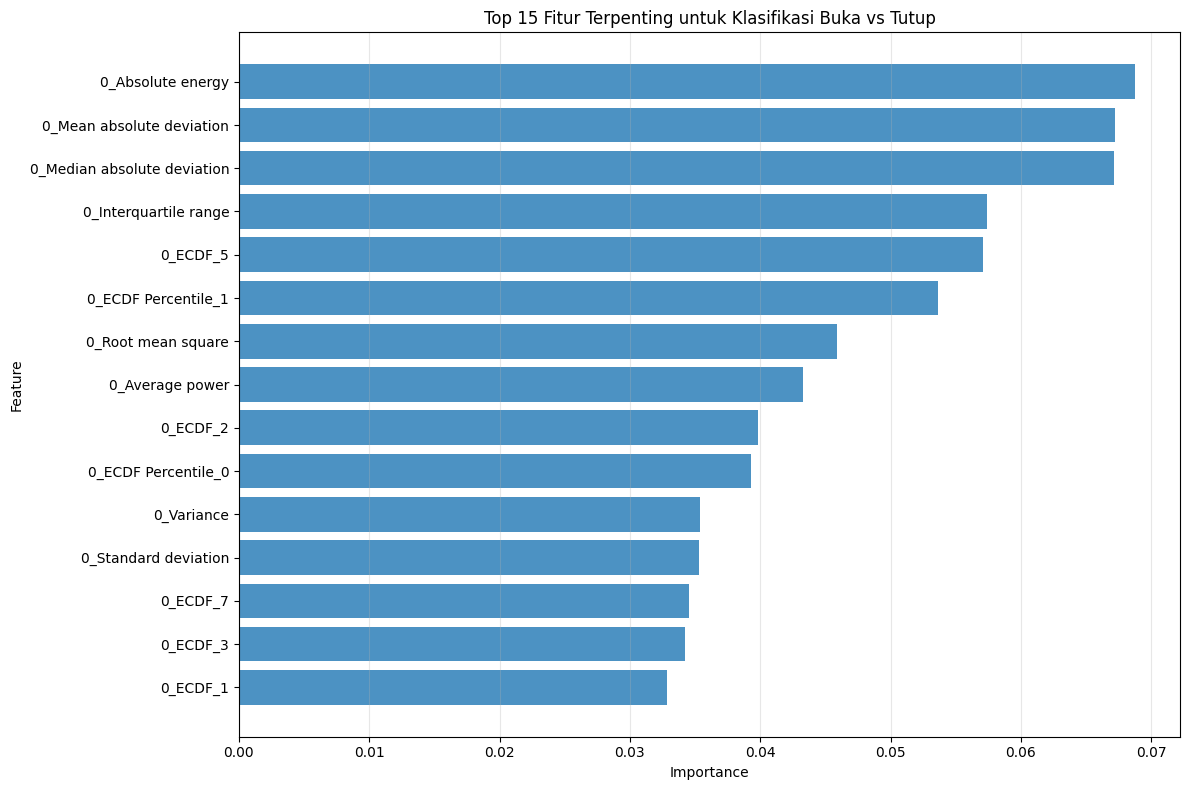


Statistik Deskriptif untuk Top 5 Fitur:

0_Absolute energy:
  Buka  - Mean: 671.8615, Std: 281.6883
  Tutup - Mean: 1041.5223, Std: 251.7558

0_Mean absolute deviation:
  Buka  - Mean: 0.0817, Std: 0.0190
  Tutup - Mean: 0.1499, Std: 0.0548

0_Median absolute deviation:
  Buka  - Mean: 0.0383, Std: 0.0233
  Tutup - Mean: 0.0931, Std: 0.0344

0_Interquartile range:
  Buka  - Mean: 0.0767, Std: 0.0465
  Tutup - Mean: 0.1861, Std: 0.0686

0_ECDF_5:
  Buka  - Mean: 0.0002, Std: 0.0001
  Tutup - Mean: 0.0003, Std: 0.0002


In [26]:
# Ambil feature importance dari Random Forest
rf_model = models['Random Forest']
feature_importance = rf_model.feature_importances_

# Buat DataFrame untuk feature importance
feature_names_clean = X_clean.drop(columns=['label', 'filename']).columns
importance_df = pd.DataFrame({
    'feature': feature_names_clean,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Tampilkan top 20 fitur terpenting
print("Top 20 Fitur Terpenting:")
print(importance_df.head(20))

# Visualisasi top 15 fitur
plt.figure(figsize=(12, 8))
top_n = 15
top_features = importance_df.head(top_n)
plt.barh(range(top_n), top_features['importance'].values, alpha=0.8)
plt.yticks(range(top_n), top_features['feature'].values)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Fitur Terpenting untuk Klasifikasi Buka vs Tutup')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Statistik deskriptif untuk top 5 fitur
print("\nStatistik Deskriptif untuk Top 5 Fitur:")
top_5_features = importance_df.head(5)['feature'].values
X_with_labels = X_clean.copy()

for feature in top_5_features:
    print(f"\n{feature}:")
    print(f"  Buka  - Mean: {X_with_labels[X_with_labels['label']==0][feature].mean():.4f}, "
          f"Std: {X_with_labels[X_with_labels['label']==0][feature].std():.4f}")
    print(f"  Tutup - Mean: {X_with_labels[X_with_labels['label']==1][feature].mean():.4f}, "
          f"Std: {X_with_labels[X_with_labels['label']==1][feature].std():.4f}")